# Plot Na MOT Power Logs
Plot and analyze Na MOT Power history extracted from pickoff photodetectors (PDs).
Need to have:
- `rootfolder`: path to photodetector calibration parameter table that converts PD voltage (in V) to laser power (in mW). One can use the helper script `'...\instrument\mot_pd_calibration.py'` to create such a parameter table.
- `rootfolder`: path to a folder you want to plot. The notebook will automatically look through all levels of subfolders to find folders that contain image files from the experiment. The notebook then takes the `run_id` of those iamge files and retreive the corresponding dataframe (as `df`) from the breadboard. 
    - Additionally one can specify the subfolders under the rootfolder to only plot data associated with those subfolders, To do this, set `selected_folders` as a list of subfolder names. Otherwise set `selected_folders` to `None`. 

### Filepath and helper functions

In [1]:
from utility_functions import get_newest_df, load_bec1serverpath
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd
import multiprocessing as mp
import re
import itertools
import seaborn as sns
rootfolder = r'Z:\Fermicam 1 data (zcam)\2022\202209'
selected_folders = ['220915'] # specify subfolders under the rootfolder if you want to only plot results from those folders
# selected_folders = None  # alternatively leave as None to select all sub folders under the rootfolder
calibration_filepath = r'instruments\MOT Monitor Calibration Parameter Table_2022-09-15.csv'

In [2]:
def get_run_dirs(root, selected_dirs = False):
    """
    Get the paths of watchfolders that you want to use to check the MOT powers

    Args: 
        -root: path str of a parent directory. 
        -selected_dirs: LIST of str where each str is the directory name of a selected sub directroy 
        in the parent directory or leave as False to iterate through all subdirectories

    Return: a list of paths of run folders

    """
    from glob import glob
    run_dirs = []
    if selected_dirs == False:
        selected_dirs = [dir for dir in os.listdir(root)]

    #if provided root path is a specific experimental run: 
    if any('.spe' in dir for dir in selected_dirs):
        run_dirs = [root]
    #if provided root path is a specific day:
    elif any('run' in dir for dir in selected_dirs): 
        for dir in selected_dirs:
            if 'run' in dir:
                path = os.path.abspath(os.path.join(root, dir))
                run_dirs += [path]
    #if provided root path is a specific month or above:
    else:
        for dir in selected_dirs:
            path = os.path.abspath(os.path.join(root, dir))
            run_dirs += glob(path + r'/**/run*/', recursive=True)

    return run_dirs    
    
def calibrate_MOT_monitor(calibration_filepath):
    df_fits = pd.read_csv(calibration_filepath, index_col=0)
    for port in df_fits.columns:
        func = np.poly1d(df_fits[port])
        voltages = df[f'NaMOT_{port}_mean_in_mv']/1000
        powers  = func(voltages)
        df[f'NaMOT_{port}_mean_in_mw'] = powers

def show_MOT_stat(df):
    mean = df[NaMOT_ports+['Na_TFx']].mean()
    std = df[NaMOT_ports+['Na_TFx']].std()
    percent_drift = 100*std/mean
    port_label = [port.split('_')[1] for port in NaMOT_ports] + ['Na_TFx']
    df_stat = pd.concat([mean,percent_drift],axis=1)
    df_stat.index = port_label
    df_stat.columns = ['Mean Laser Power [mW]', '% Standard Deviation']
    return df_stat

### Retrieve and clean up data from breadboard

In [3]:
watchfolders = get_run_dirs(rootfolder,selected_folders)
print('Found ' + str(len(watchfolders)) + ' run folders to monitor Na MOT powers')

Found 10 run folders to monitor Na MOT powers


In [4]:
df = pd.concat([get_newest_df(folder) for folder in watchfolders])
print('Imported dataframe shape: '+ str(df.shape))

Imported dataframe shape: (632, 62)


In [5]:
#Clean up: indexing, datetime formatting, ordering
df.index = df['run_id']
times = [datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%SZ") for timestamp in df['runtime (format: %Y-%m-%dT%H:%M:%SZ)']]
df['datetimes'] = times
df = df.sort_values(by='datetimes')

In [6]:
#Convert MOT montor photodetector voltage to laser power
calibrate_MOT_monitor(calibration_filepath)
NaMOT_ports = [k for k in df.columns if re.search('NaMOT(.*)mean_in_mw',k)]
df['NaMOT_Total_mean_in_mw'] = df[NaMOT_ports].sum(axis=1)
NaMOT_ports += ['NaMOT_Total_mean_in_mw']

### Summary plots

In [7]:
show_MOT_stat(df)

,Mean Laser Power [mW],% Standard Deviation
Top,12.286877,6.333151
Bottom,20.116784,6.374704
NaSlower,15.875162,5.047669
NaSlowerWindow,15.538998,4.990292
KSlower,15.003051,4.953555
KSlowerWindow,15.977521,4.941534
Total,94.648395,5.840193
Na_TFx,51.669548,15.317531


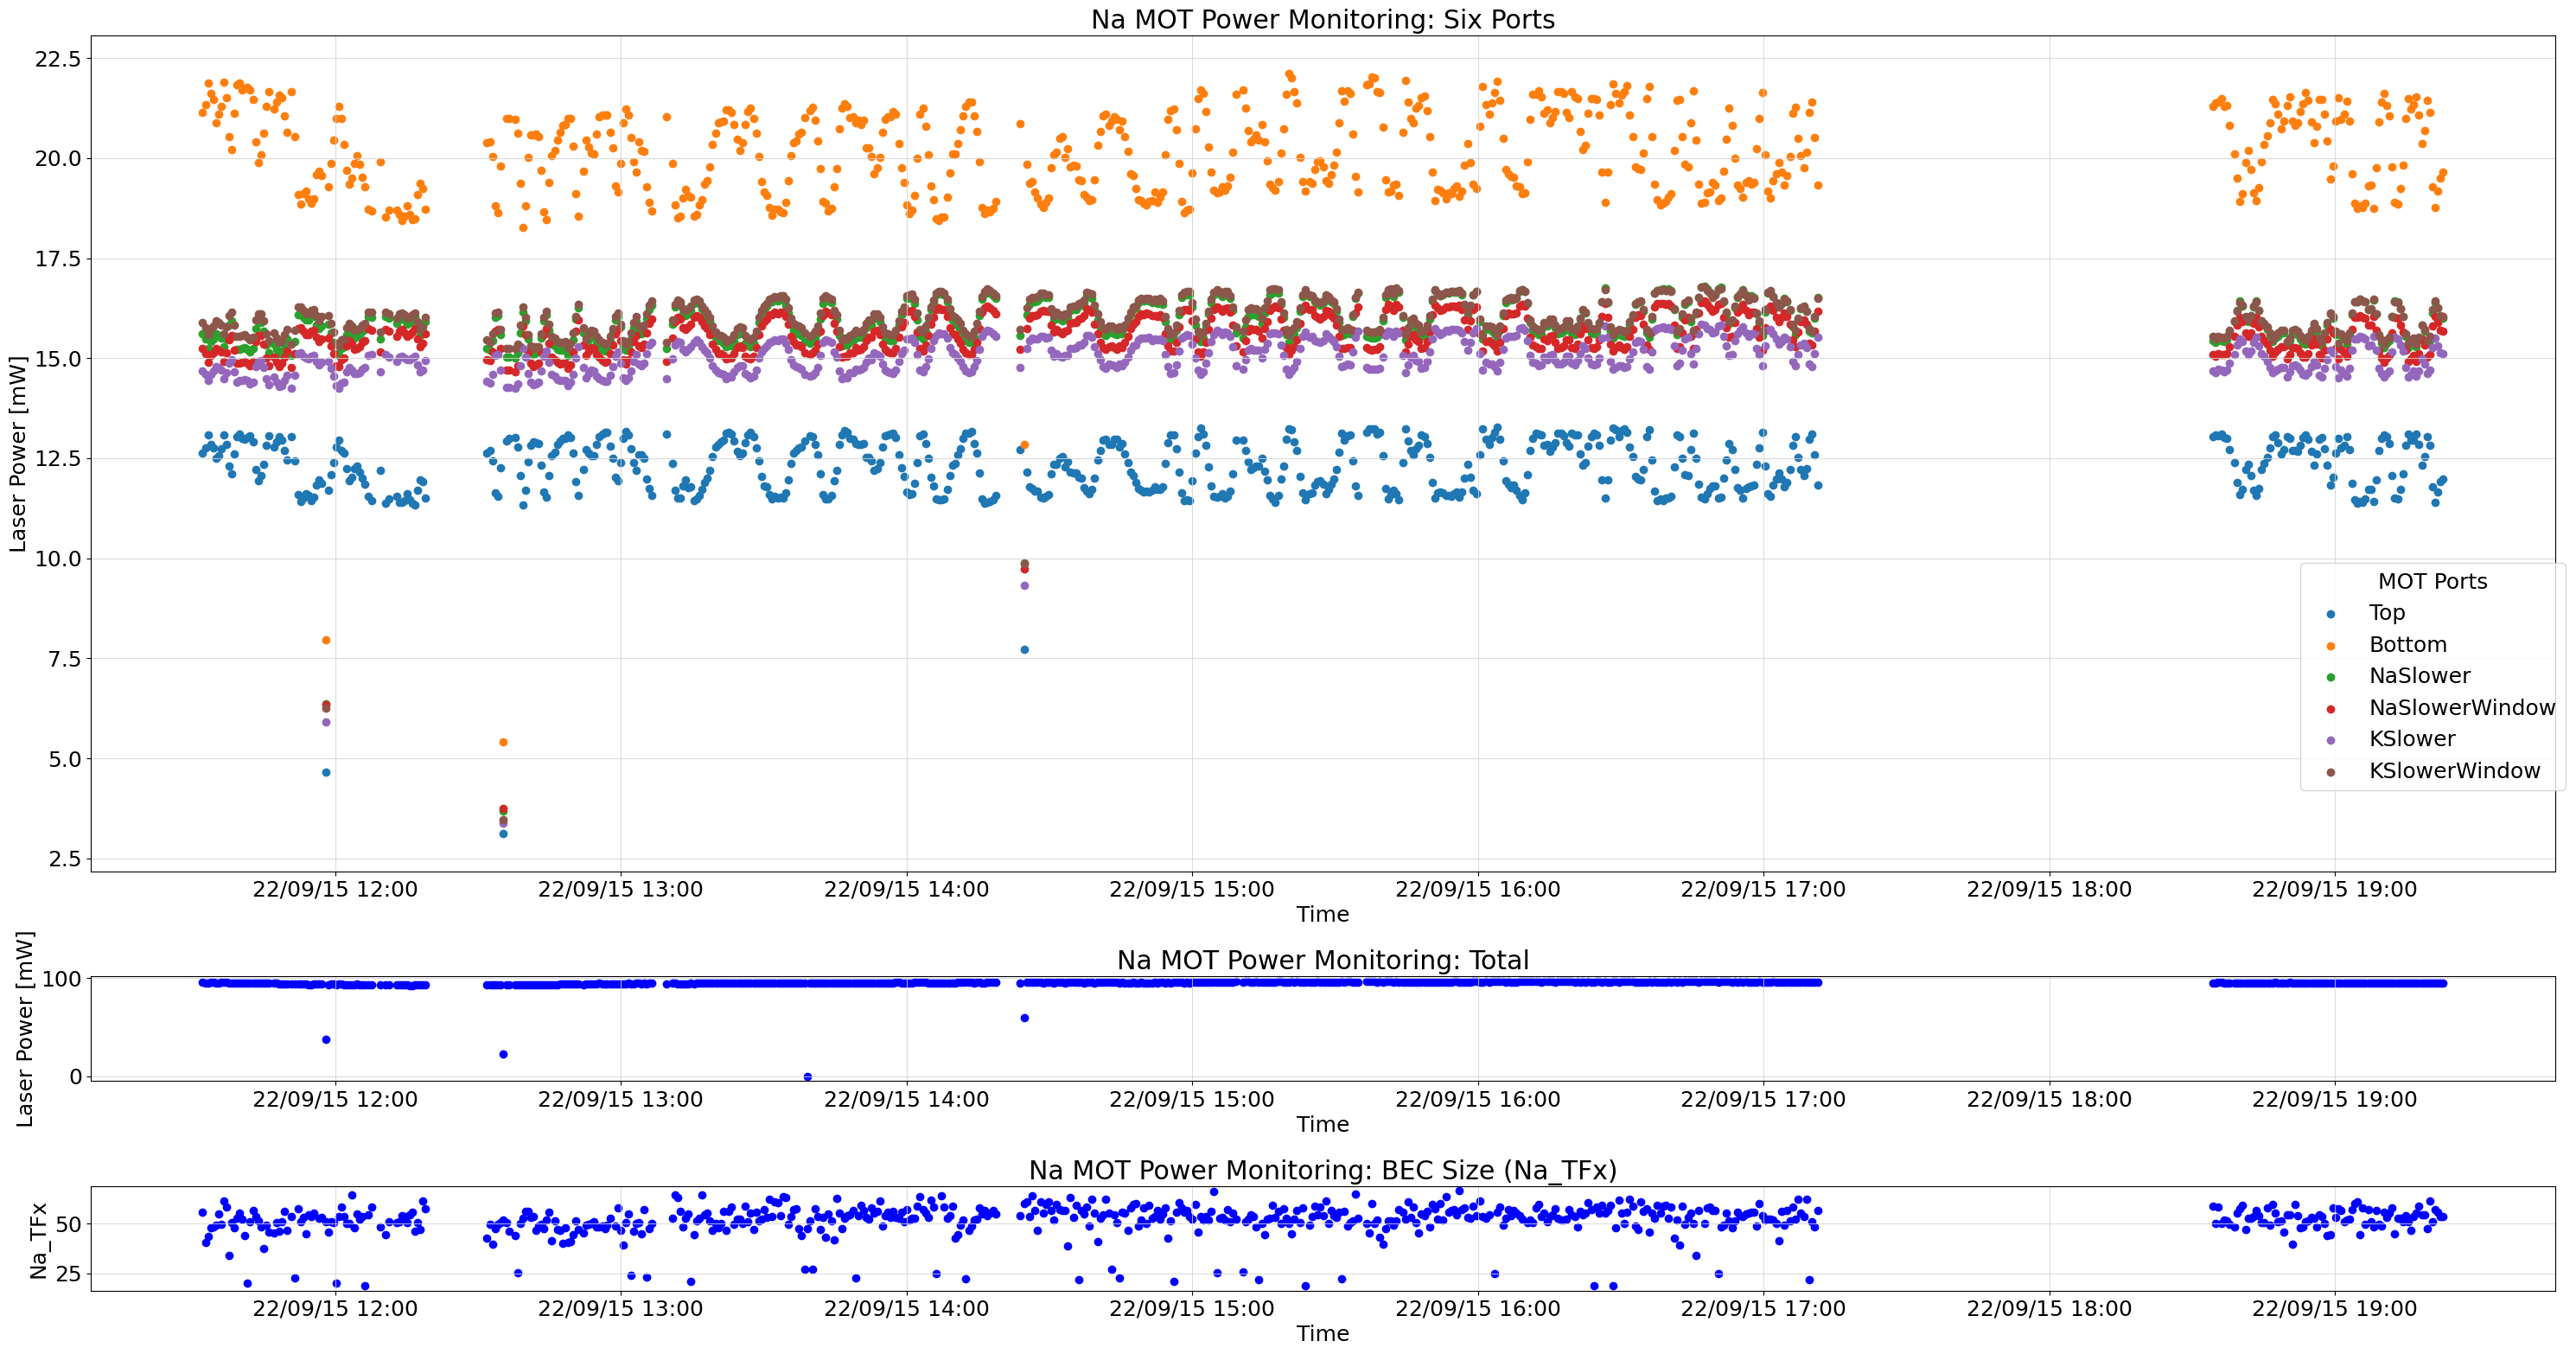

In [8]:
plt.rcParams.update({'font.size': 18})
fig, [ax1,ax2, ax3] = plt.subplots(3,1,figsize=(30,16),sharex=True, gridspec_kw={'height_ratios': [4, 0.5, 0.5]})
for port in NaMOT_ports[:-1]:
    label = port.split('_')[1]
    ax1.scatter(df['datetimes'],df[port],label=label)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Laser Power [mW]')
    ax1.xaxis.set_tick_params(labelbottom=True)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d %H:%M'))
    ax1.grid(color='lightgray', alpha=0.8)
    ax1.set_title('Na MOT Power Monitoring: Six Ports')


ax2.scatter(df['datetimes'],df['NaMOT_Total_mean_in_mw'],color='blue')
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_xlabel('Time')
ax2.set_ylabel('Laser Power [mW]')
ax2.grid(color='lightgray', alpha=0.8)
ax2.set_title('Na MOT Power Monitoring: Total')

ax3.scatter(df['datetimes'],df['Na_TFx'],color='blue')
ax3.xaxis.set_tick_params(labelbottom=True)
ax3.set_xlabel('Time')
ax3.set_ylabel('Na_TFx')
ax3.grid(color='lightgray', alpha=0.8)
ax3.set_title('Na MOT Power Monitoring: BEC Size (Na_TFx)')

fig.legend(loc='right', ncol = 1, title='MOT Ports')
plt.tight_layout()
# mpld3.display()

### More plots: normalized time series and correlations

In [9]:
#Normalize time series to see drifts in percentages. TODO: Handle NaN values of Na_TFx
startlogging_idx = df['NaMOT_Top_mean_in_mw'].index.get_loc(df['NaMOT_Top_mean_in_mw'].first_valid_index())
print('Normalizing all relevant time series with the following starting values: ')
print(df[NaMOT_ports+['Na_TFx']].iloc[startlogging_idx].to_string())


Normalizing all relevant time series with the following starting values: 
NaMOT_Top_mean_in_mw               12.636098
NaMOT_Bottom_mean_in_mw            21.131478
NaMOT_NaSlower_mean_in_mw          15.601944
NaMOT_NaSlowerWindow_mean_in_mw    15.236632
NaMOT_KSlower_mean_in_mw           14.689462
NaMOT_KSlowerWindow_mean_in_mw     15.889924
NaMOT_Total_mean_in_mw             95.185539
Na_TFx                             55.601135


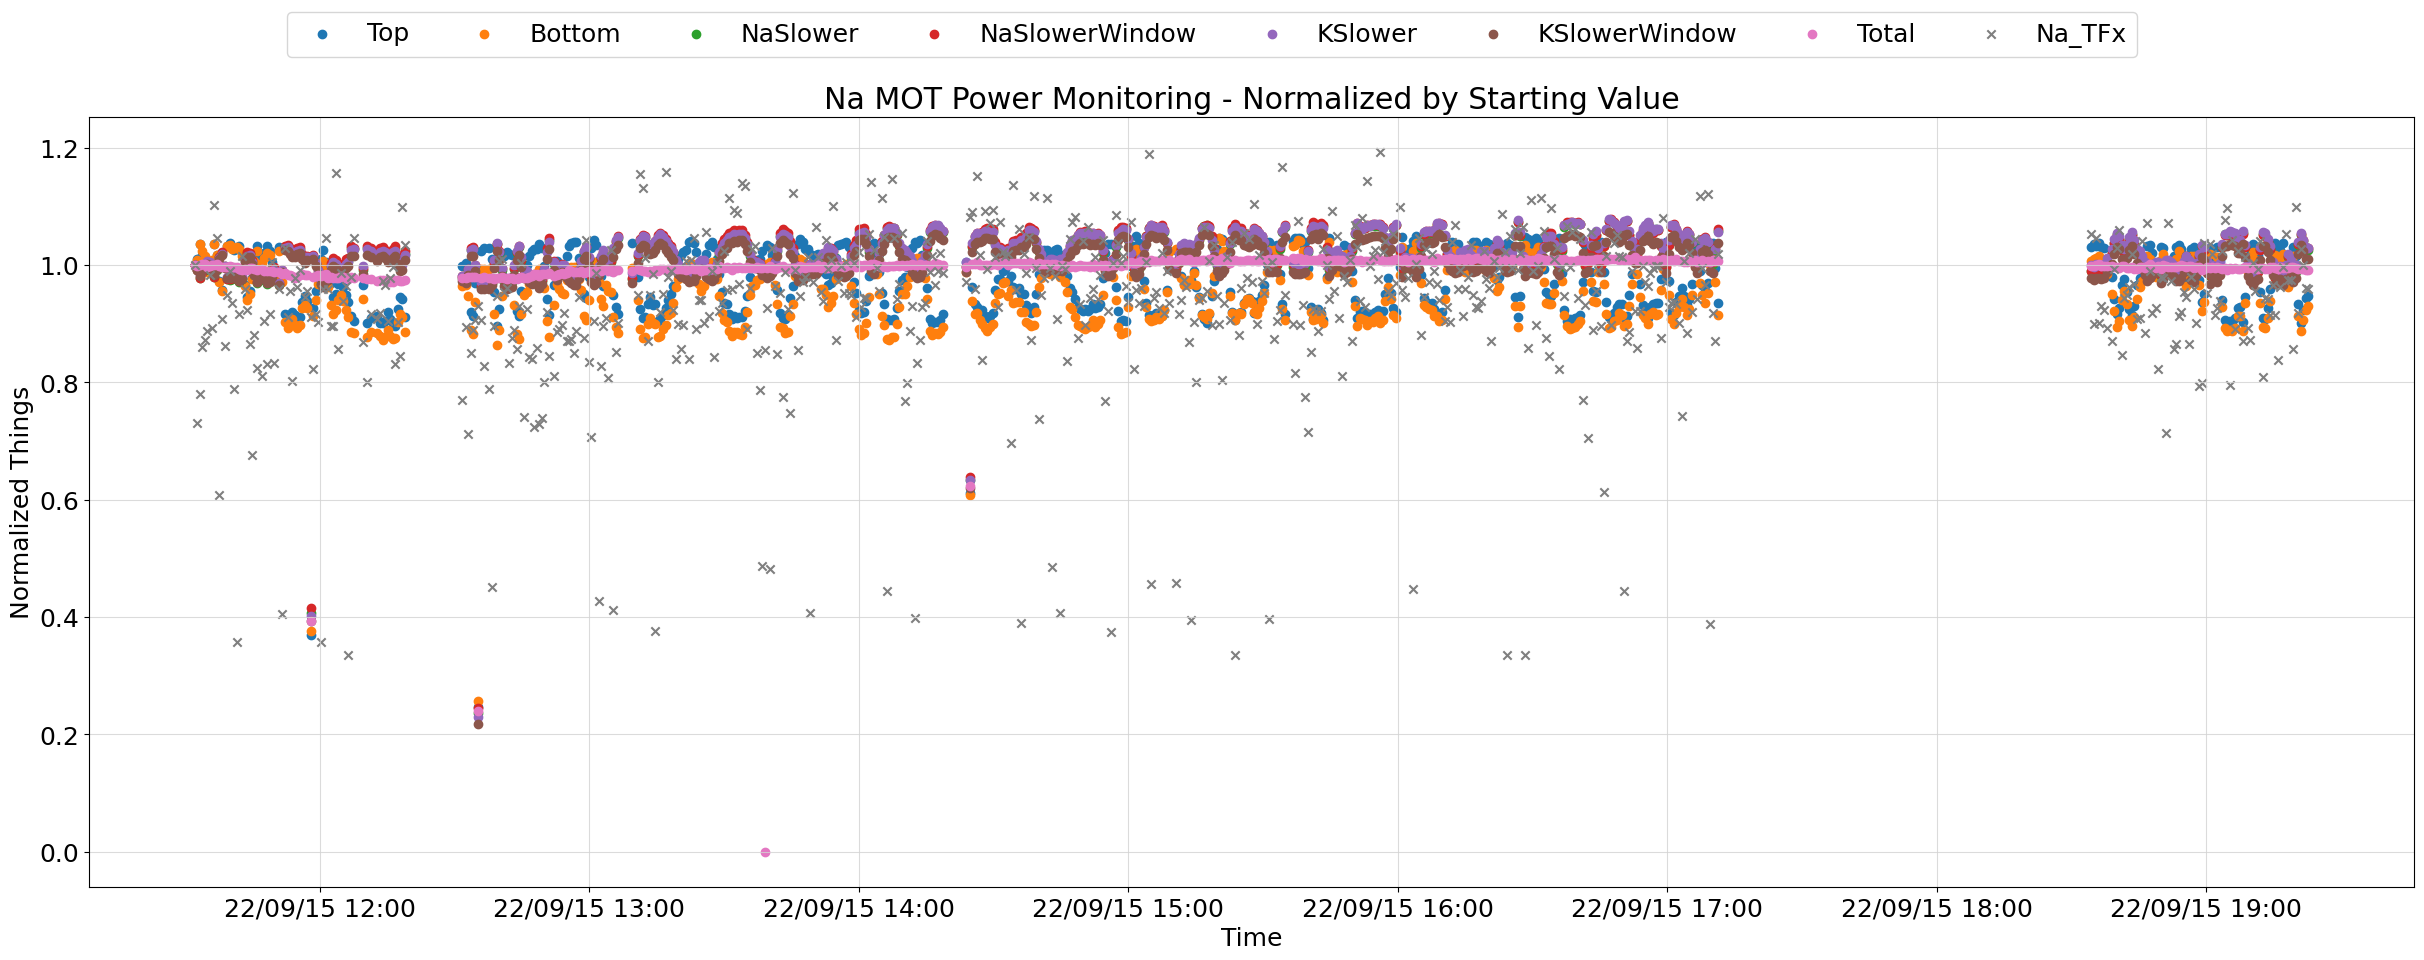

In [10]:
fig, ax = plt.subplots(figsize=(30,10))
for port in NaMOT_ports:
    label = port.split('_')[1]
    start_value = df[port].iloc[startlogging_idx]
    ax.scatter(df['datetimes'],df[port]/start_value,label=label)
ax.scatter(df['datetimes'], df['Na_TFx']/df['Na_TFx'].iloc[startlogging_idx], label='Na_TFx',marker='x')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d %H:%M'))

# ax.set_xlim([datetime(2022,9,13,13,30), datetime(2022,9,13,19,10)])

ax.set_xlabel('Time')
ax.set_ylabel('Normalized Things')
ax.set_title('Na MOT Power Monitoring - Normalized by Starting Value')
fig.legend(loc='upper center', ncol = 8)
ax.grid(color='lightgray', alpha=0.8)

# mpld3.display(fig)

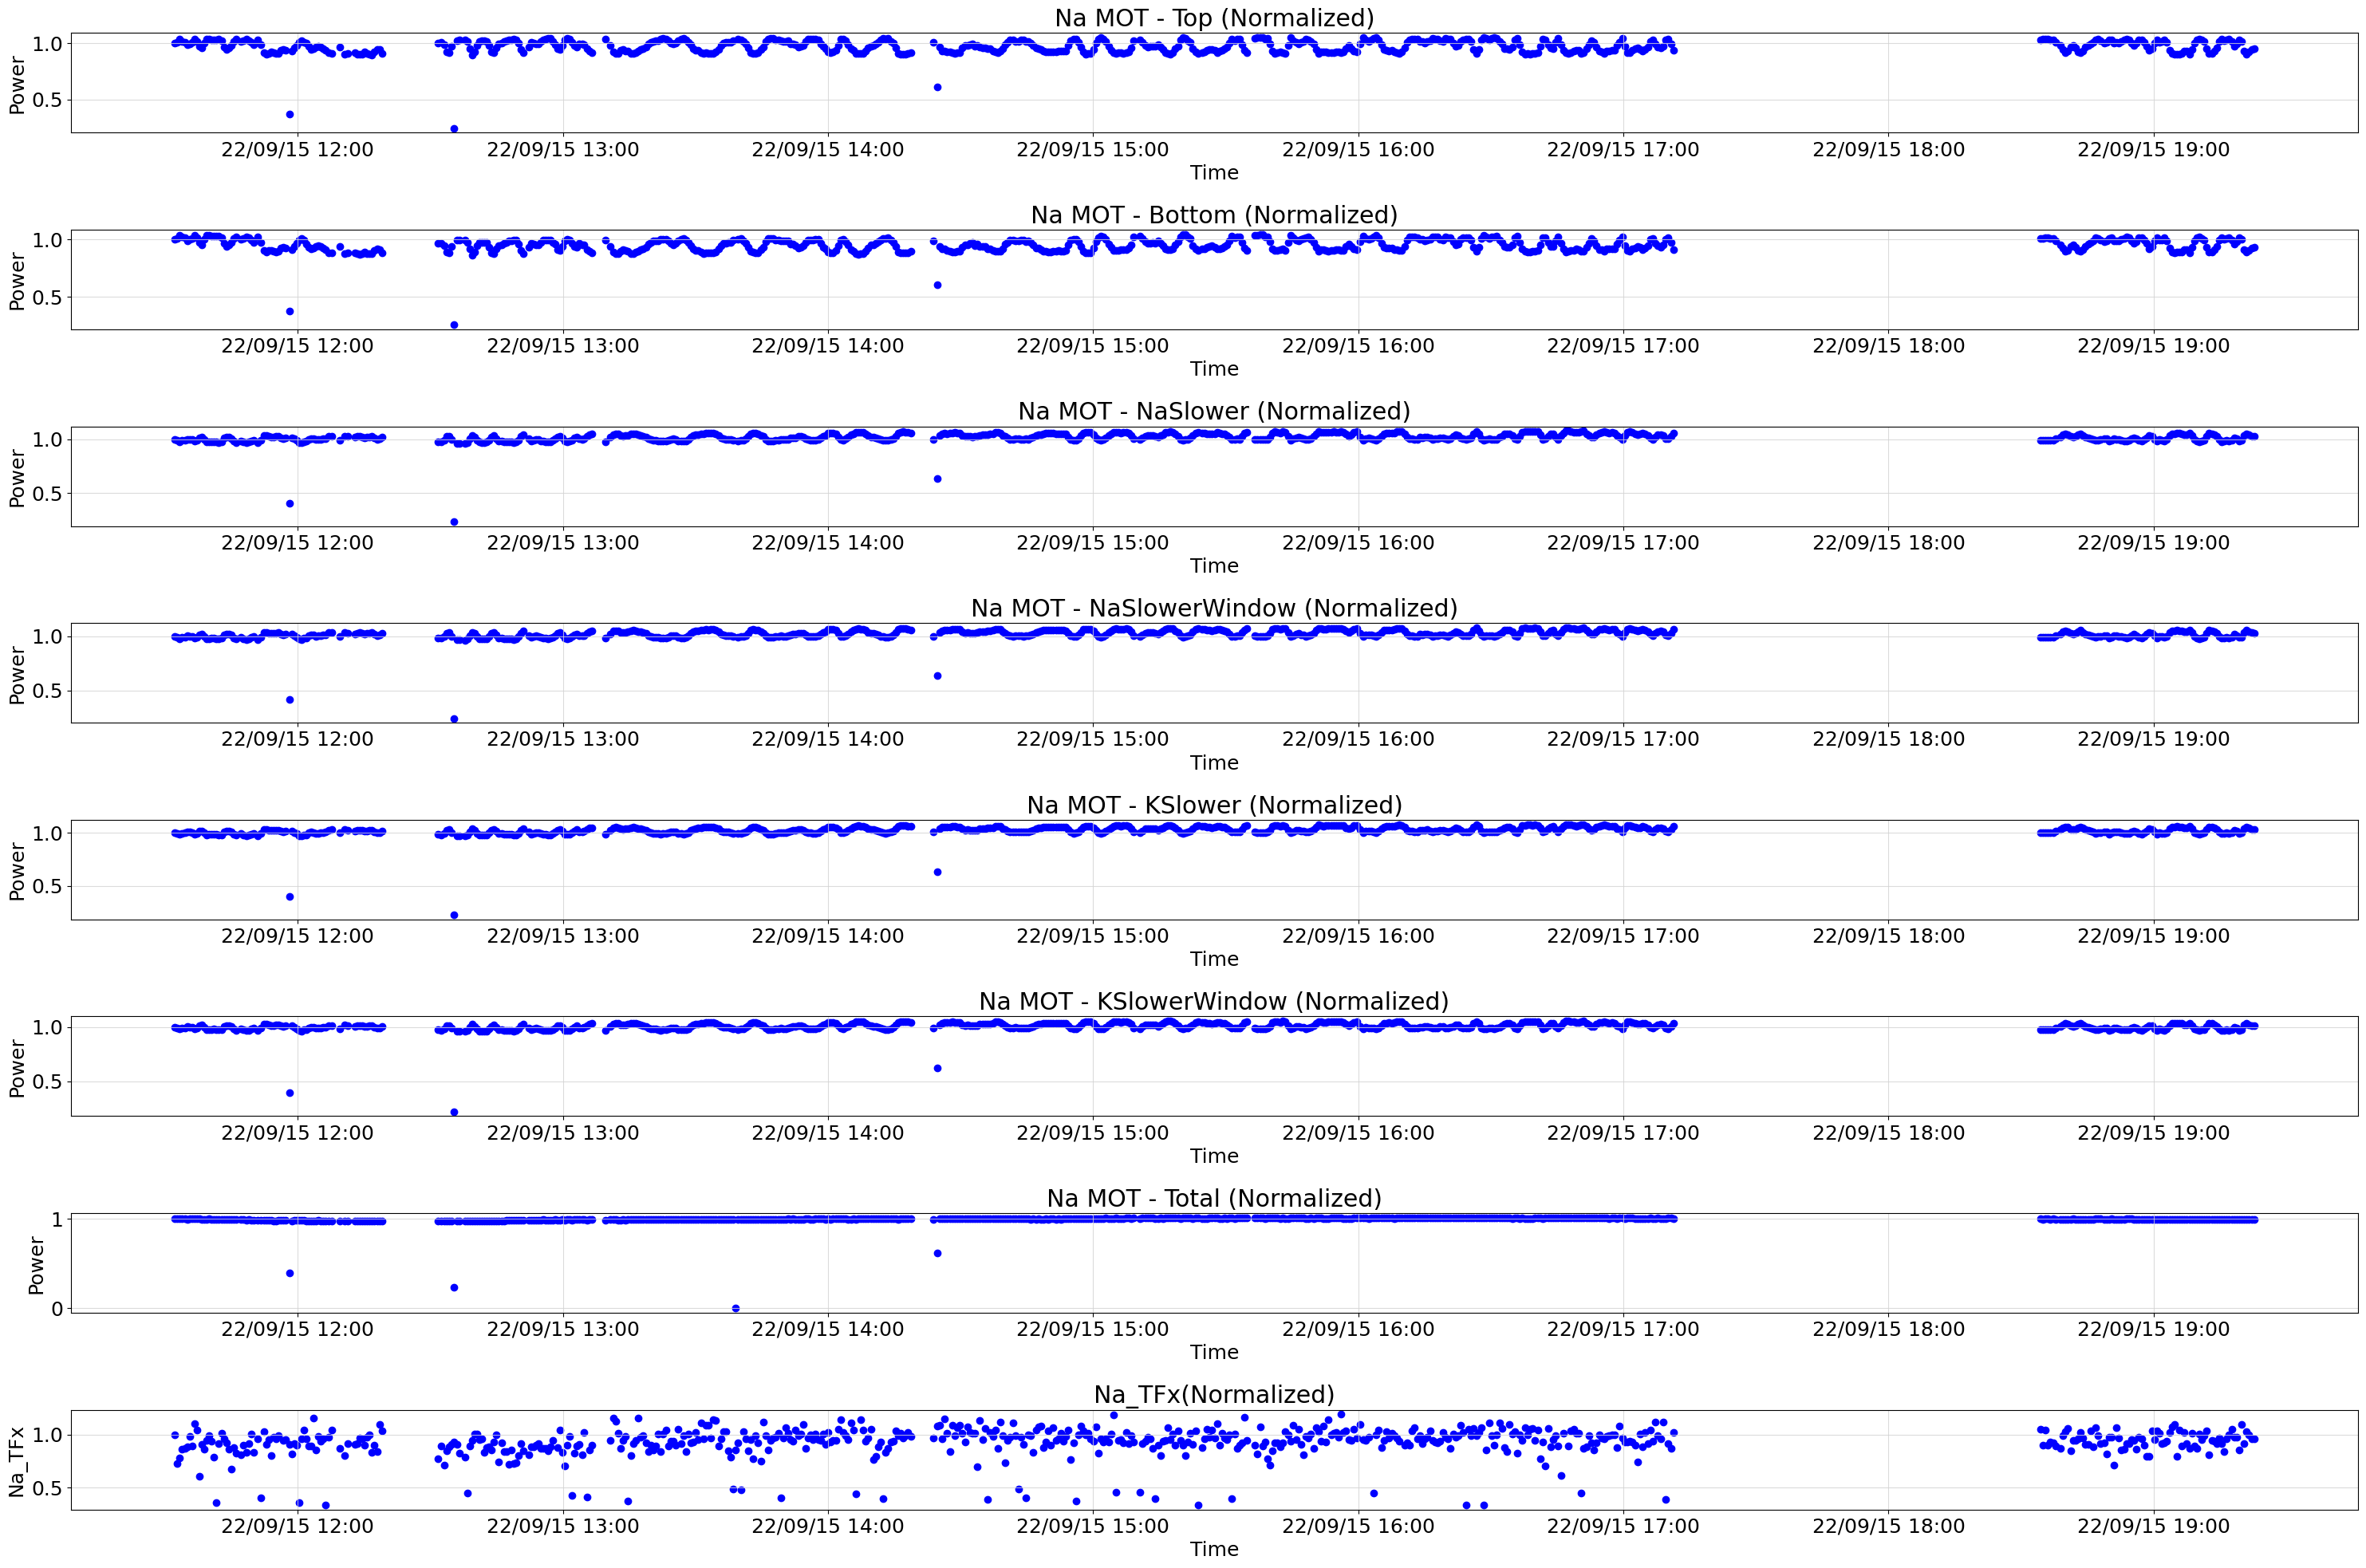

In [11]:
fig, axes = plt.subplots(8,1,sharex=True,figsize=(30,20))
for port, ax in zip(NaMOT_ports, axes[:-1]):
    label = port.split('_')[1]
    start_value = df[port].iloc[startlogging_idx]
    ax.scatter(df['datetimes'],df[port]/start_value,label=label,color='blue')
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.grid(color='lightgray', alpha=0.8)
    ax.set_xlabel('Time')
    ax.set_ylabel('Power')
    ax.set_title(f'Na MOT - {label} (Normalized)')



axes[-1].scatter(df['datetimes'], df['Na_TFx']/df['Na_TFx'].iloc[startlogging_idx], label='Na_TFx',color='blue')
axes[-1].grid(color='lightgray', alpha=0.8)
axes[-1].set_xlabel('Time')
axes[-1].set_ylabel('Na_TFx')
axes[-1].set_title('Na_TFx(Normalized)')
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d %H:%M'))

# axes[0].set_xlim([datetime(2022,9,13,13,30), datetime(2022,9,13,19,10)])
plt.tight_layout()


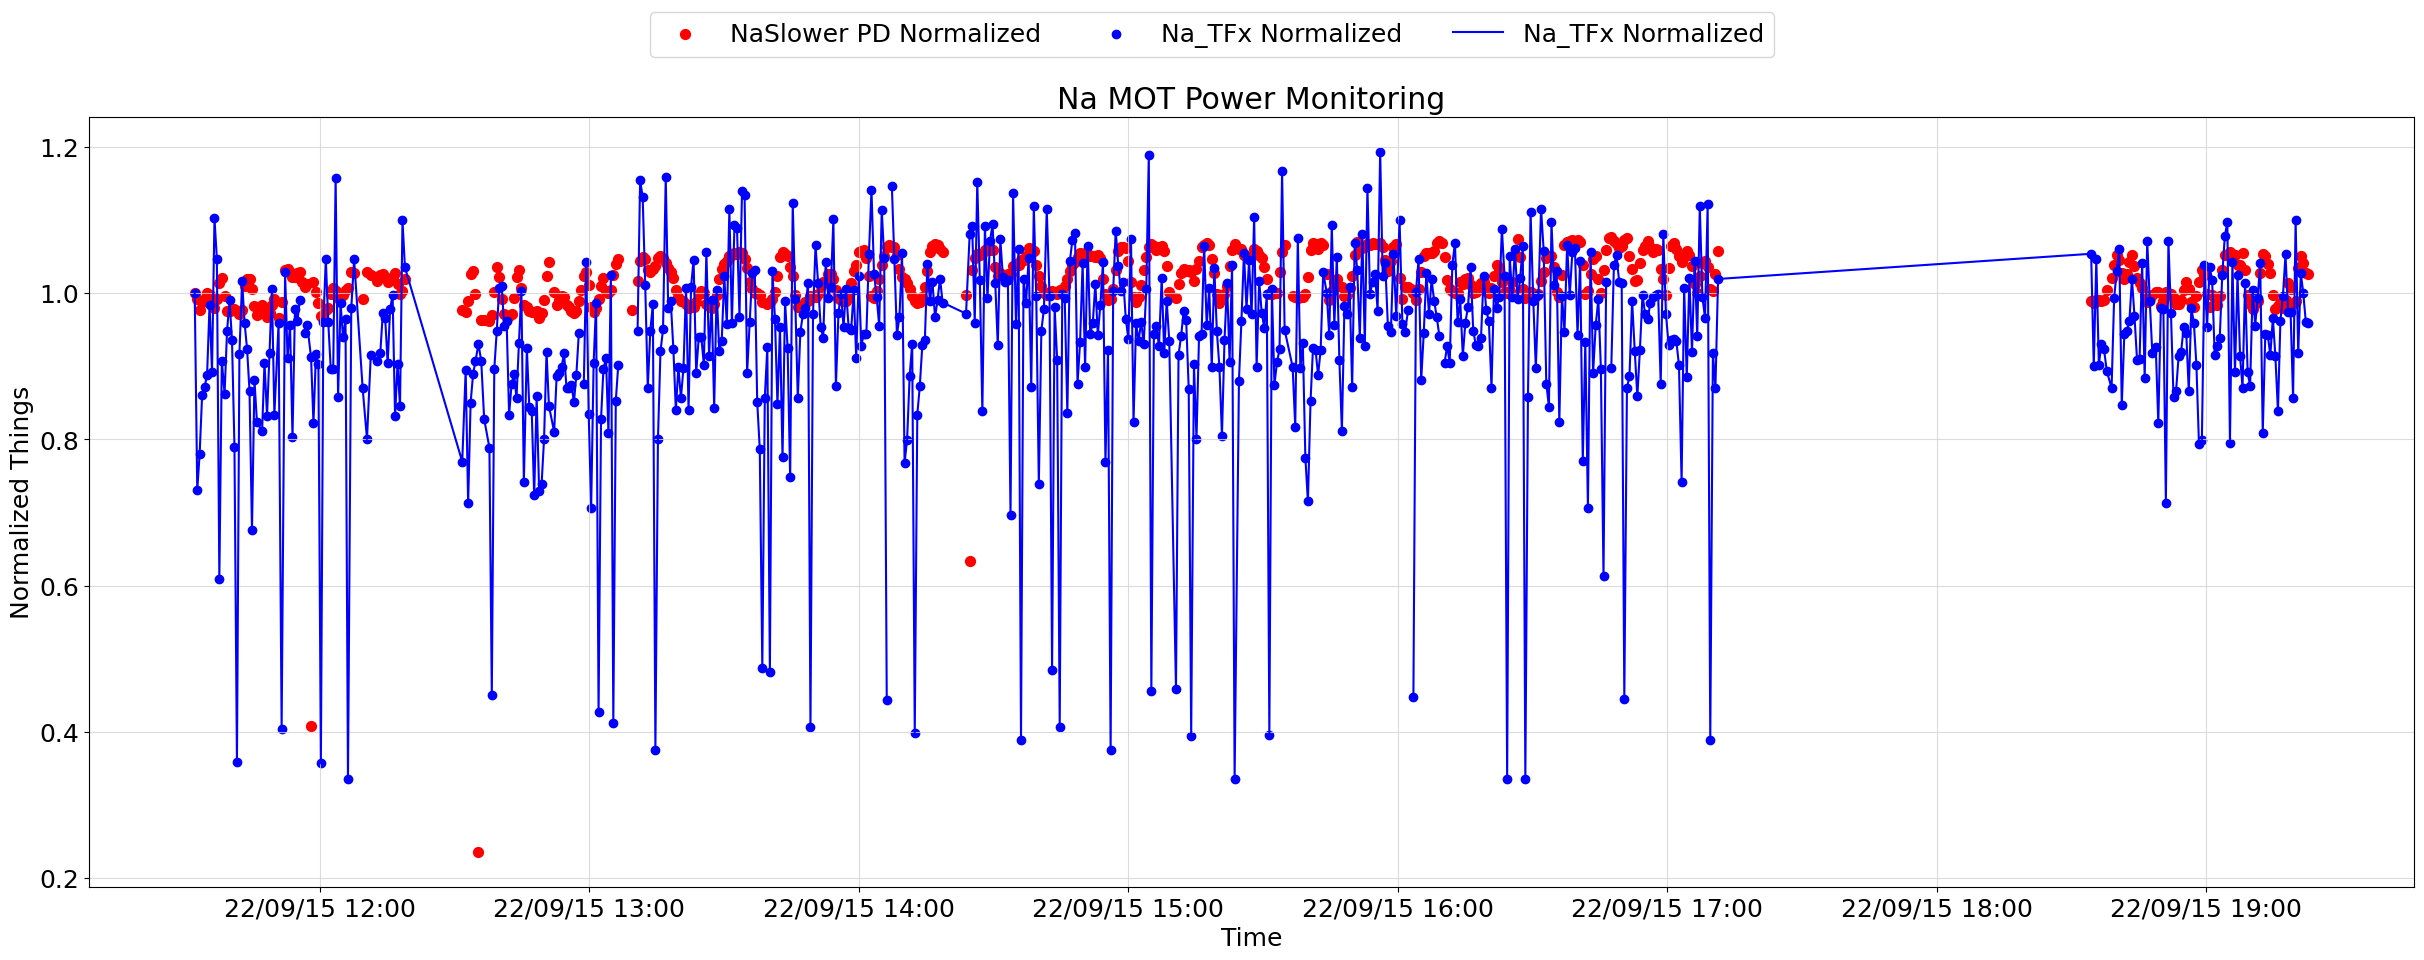

In [12]:
fig, ax = plt.subplots(figsize=(30,10))
ax.scatter(df['datetimes'], df['NaMOT_NaSlower_mean_in_mw']/df['NaMOT_NaSlower_mean_in_mw'].iloc[startlogging_idx], 
            label='NaSlower PD Normalized',
            color='red',
            s=50
            )
ax.scatter(df['datetimes'], df['Na_TFx']/df['Na_TFx'].iloc[startlogging_idx], label='Na_TFx Normalized',color='blue')
ax.plot(df['datetimes'], df['Na_TFx']/df['Na_TFx'].iloc[startlogging_idx], label='Na_TFx Normalized',color='blue')

# ax.set_xlim([datetime(2022,9,13,13,30), datetime(2022,9,13,19,10)])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d %H:%M'))
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Things')
ax.set_title('Na MOT Power Monitoring')
fig.legend(loc='upper center', ncol = 3)
ax.grid(color='lightgray', alpha=0.8)

# mpld3.display(fig)

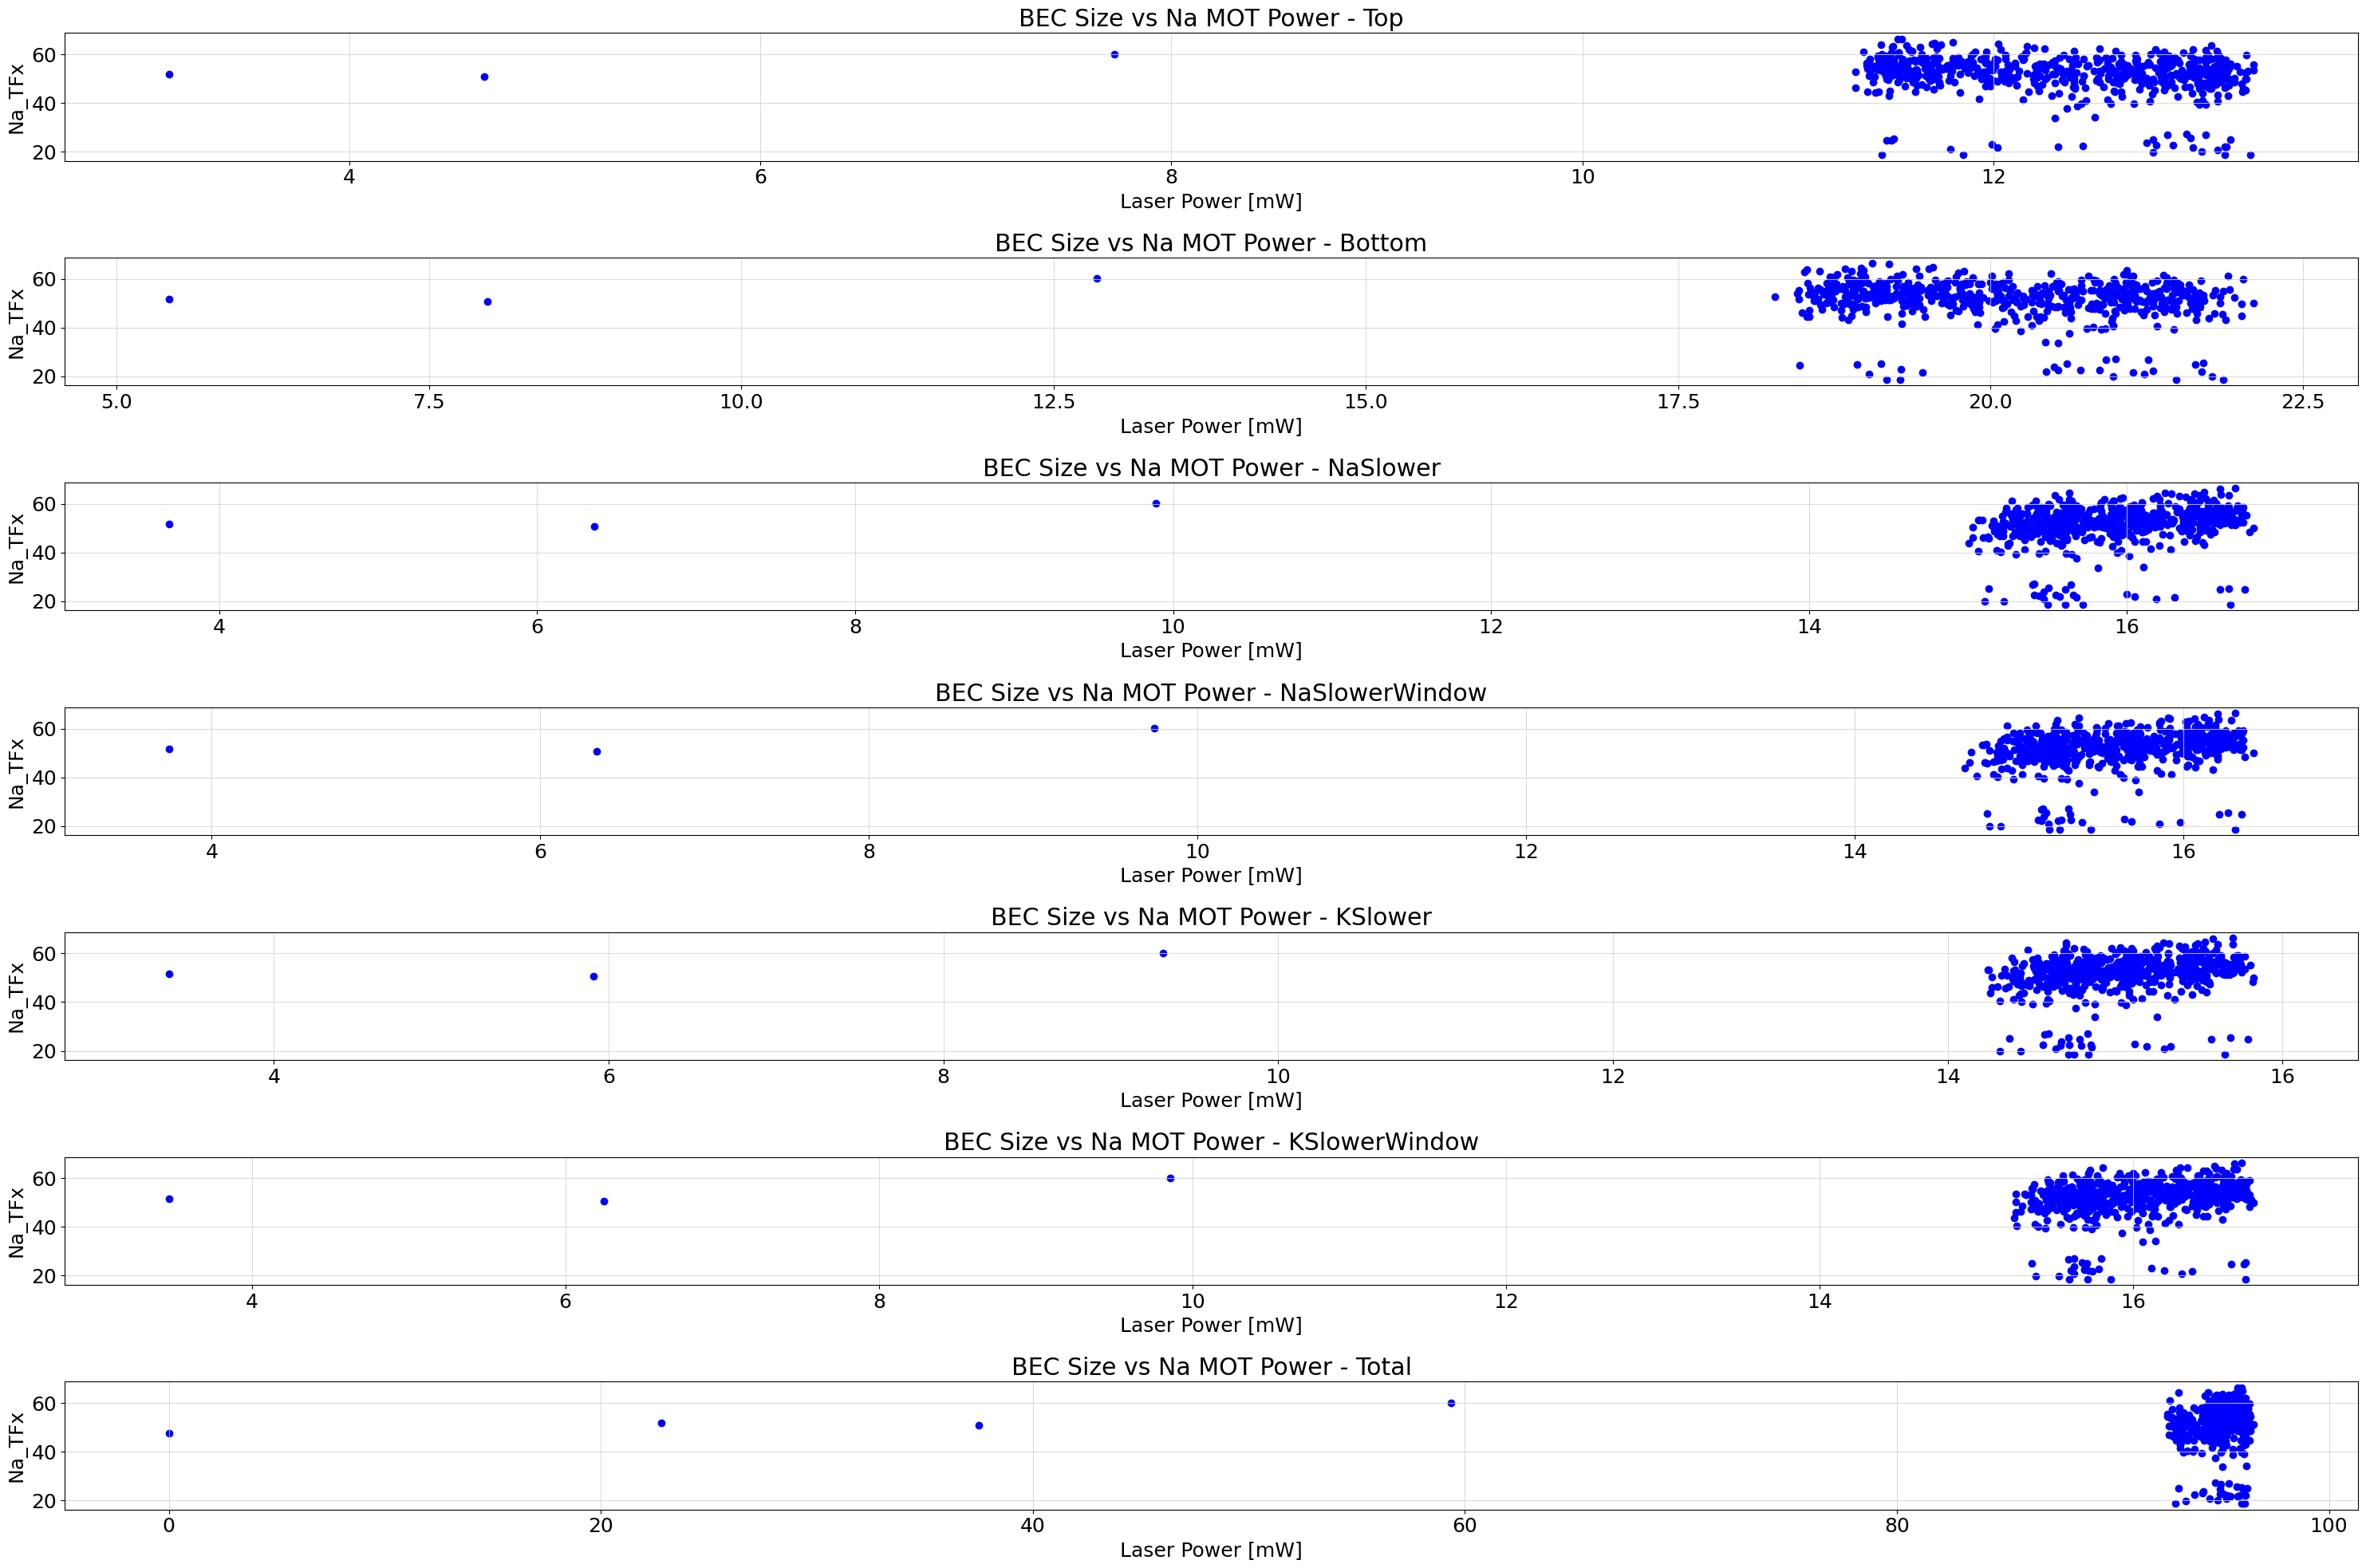

In [13]:
fig, axes = plt.subplots(7,1,sharey=True,figsize=(30,20))
for port, ax in zip(NaMOT_ports, axes):
    label = port.split('_')[1]
    ax.scatter(df[port], df['Na_TFx'],color='blue')
    ax.grid(color='lightgray', alpha=0.8)
    ax.set_xlabel('Laser Power [mW]')
    ax.set_ylabel('Na_TFx')
    ax.set_title(f'BEC Size vs Na MOT Power - {label}')
plt.tight_layout()

<AxesSubplot:title={'center':'Correlation Matrix'}>

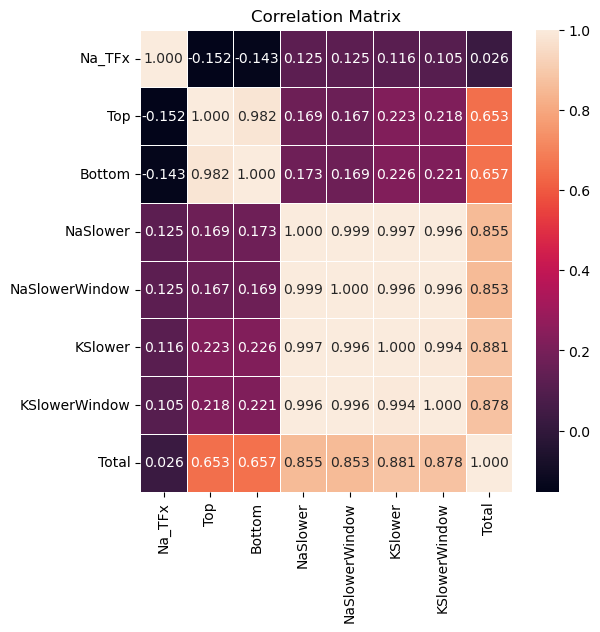

In [14]:
corrmat = df[['Na_TFx'] + NaMOT_ports].corr().round(5)
corrmat.columns = (['Na_TFx']+[port.split('_')[1] for port in NaMOT_ports])
corrmat.index = (['Na_TFx']+[port.split('_')[1] for port in NaMOT_ports])
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Correlation Matrix')
sns.heatmap(corrmat, annot=True, fmt='.3f',linewidths=0.5, ax=ax)